In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import

In [33]:
import pandas as pd
import numpy as np
from pprint import pprint
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import time
from _operator import itemgetter
from math import sqrt
import random 
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
df1=pd.read_csv("./data/20170101_prestage.csv")

In [35]:
df=df1.drop("Unnamed: 0",1)
df.columns

Index(['profile', 'category1', 'canonicalUrl', 'referrerHostClass',
       'sessionStop', 'userId', 'publishtime', 'sessionStart', 'referrerUrl',
       'keywords', 'id', 'eventId', 'city', 'title', 'url', 'country',
       'region', 'author', 'referrerSearchEngine', 'deviceType', 'time', 'os',
       'activeTime', 'sessionNo', 'activeTotalTime', 'articleId'],
      dtype='object')

# Choose Variables

In [36]:
articles=df["id"].unique()
d={}
for i in range(len(articles)):
    article=articles[i]
    d[article]=i
df["articleId"]=df["id"].map(d)
df.columns

Index(['profile', 'category1', 'canonicalUrl', 'referrerHostClass',
       'sessionStop', 'userId', 'publishtime', 'sessionStart', 'referrerUrl',
       'keywords', 'id', 'eventId', 'city', 'title', 'url', 'country',
       'region', 'author', 'referrerSearchEngine', 'deviceType', 'time', 'os',
       'activeTime', 'sessionNo', 'activeTotalTime', 'articleId'],
      dtype='object')

In [37]:
#data=df[["sessionNo","category_num","time"]].rename(columns={"sessionNo":"session_key","category_num": "item_key", "time":"time_key"})
data_1=df[["sessionNo","articleId","time","city","region","deviceType"]].rename(columns={"sessionNo":"session_key","articleId": "item_key", "time":"time_key"})
print("The length of data with article as itemid: ",len(data_1))
data_1.head()

The length of data with article as itemid:  374487


,session_key,item_key,time_key,city,region,deviceType
0,2,0,1483305738,oslo,oslo,Desktop
1,2,1,1483305786,oslo,oslo,Desktop
2,2,2,1483305801,oslo,oslo,Desktop
3,4,3,1483260265,brumunddal,hedmark,Desktop
4,5,4,1483271454,brumunddal,hedmark,Desktop


In [38]:
categories=df["category1"].unique()
d={}
for i in range(len(categories)):
    category=categories[i]
    d[category]=i
df["categoryId"]=df["category1"].map(d)

In [39]:
#data=df[["sessionNo","category_num","time"]].rename(columns={"sessionNo":"session_key","category_num": "item_key", "time":"time_key"})
data_2=df[["sessionNo","categoryId","time","city","region","deviceType"]].rename(columns={"sessionNo":"session_key","categoryId": "item_key", "time":"time_key"})
print("The length of data with category as itemid: ",len(data_2))
data_2.head()

The length of data with category as itemid:  374487


,session_key,item_key,time_key,city,region,deviceType
0,2,0,1483305738,oslo,oslo,Desktop
1,2,1,1483305786,oslo,oslo,Desktop
2,2,1,1483305801,oslo,oslo,Desktop
3,4,0,1483260265,brumunddal,hedmark,Desktop
4,5,2,1483271454,brumunddal,hedmark,Desktop


## DeviceType

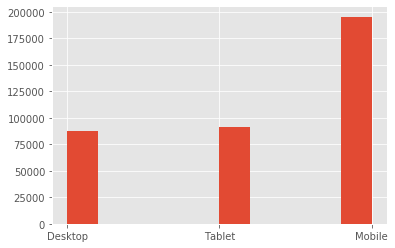

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
fig=plt.hist(data_1["deviceType"])

In [41]:
t=pd.get_dummies(data_1["deviceType"])
device_data=data_1.join(t)
device_data.to_csv("./data/day_one_article_only_device.csv")
device_data.head()

,session_key,item_key,time_key,city,region,deviceType,Desktop,Mobile,Tablet
0,2,0,1483305738,oslo,oslo,Desktop,1,0,0
1,2,1,1483305786,oslo,oslo,Desktop,1,0,0
2,2,2,1483305801,oslo,oslo,Desktop,1,0,0
3,4,3,1483260265,brumunddal,hedmark,Desktop,1,0,0
4,5,4,1483271454,brumunddal,hedmark,Desktop,1,0,0


In [42]:
t=pd.get_dummies(data_2["deviceType"])
device_data=data_2.join(t)
device_data.to_csv("./data/day_one_category_only_device.csv")
device_data.head()

,session_key,item_key,time_key,city,region,deviceType,Desktop,Mobile,Tablet
0,2,0,1483305738,oslo,oslo,Desktop,1,0,0
1,2,1,1483305786,oslo,oslo,Desktop,1,0,0
2,2,1,1483305801,oslo,oslo,Desktop,1,0,0
3,4,0,1483260265,brumunddal,hedmark,Desktop,1,0,0
4,5,2,1483271454,brumunddal,hedmark,Desktop,1,0,0


## Regions

In [43]:
k=data_1.groupby("region")["session_key"].count()
k.describe()

count       496.000000
mean        754.616935
std       10639.337693
min           1.000000
25%           2.000000
50%           4.000000
75%          13.000000
max      227906.000000
Name: session_key, dtype: float64

In [44]:
!pip install geopy

In [45]:
from geopy.geocoders import Nominatim
from tqdm import tqdm
geolocator = Nominatim(user_agent="specify_your_app_name_here")
d={}
k=data_1["region"].unique()
for i in tqdm(range(len(k))):
    try:
      location = geolocator.geocode(i)
      if not location:
          d[k[i]]=(0,0)
      else:
          d[k[i]]=(location.latitude, location.longitude)
    except:
      print(111)
      d[k[i]]=(0,0)

 37%|███▋      | 185/497 [01:31<03:02,  1.71it/s]

111


 39%|███▉      | 196/497 [01:36<02:56,  1.70it/s]

111


 42%|████▏     | 209/497 [01:42<02:51,  1.67it/s]

111


 44%|████▍     | 220/497 [01:47<02:43,  1.70it/s]

111


 47%|████▋     | 233/497 [01:53<02:36,  1.69it/s]

111


 49%|████▉     | 245/497 [01:58<02:28,  1.70it/s]

111


 52%|█████▏    | 256/497 [02:03<02:21,  1.70it/s]

111


 54%|█████▎    | 267/497 [02:08<02:14,  1.71it/s]

111


 56%|█████▌    | 278/497 [02:13<02:07,  1.72it/s]

111


 58%|█████▊    | 288/497 [02:18<02:02,  1.71it/s]

111


 60%|██████    | 299/497 [02:23<01:55,  1.71it/s]

111


 63%|██████▎   | 311/497 [02:28<01:49,  1.70it/s]

111


 65%|██████▍   | 321/497 [02:33<01:43,  1.71it/s]

111


 67%|██████▋   | 332/497 [02:38<01:36,  1.71it/s]

111


 69%|██████▉   | 342/497 [02:42<01:30,  1.72it/s]

111


 71%|███████   | 352/497 [02:47<01:24,  1.73it/s]

111


 73%|███████▎  | 362/497 [02:51<01:18,  1.73it/s]

111


 75%|███████▍  | 372/497 [02:56<01:12,  1.72it/s]

111


 77%|███████▋  | 382/497 [03:00<01:06,  1.73it/s]

111


 79%|███████▉  | 392/497 [03:05<01:01,  1.72it/s]

111


 81%|████████  | 401/497 [03:09<00:55,  1.73it/s]

111


 83%|████████▎ | 412/497 [03:14<00:49,  1.72it/s]

111


 85%|████████▌ | 423/497 [03:19<00:43,  1.70it/s]

111


 87%|████████▋ | 434/497 [03:24<00:37,  1.69it/s]

111


 90%|████████▉ | 446/497 [03:29<00:30,  1.69it/s]

111


 92%|█████████▏| 456/497 [03:34<00:24,  1.70it/s]

111


 94%|█████████▍| 468/497 [03:39<00:17,  1.70it/s]

111


 96%|█████████▌| 478/497 [03:44<00:11,  1.72it/s]

111


 98%|█████████▊| 488/497 [03:48<00:05,  1.72it/s]

111


100%|██████████| 497/497 [03:52<00:00,  2.14it/s]


In [46]:
l=[[],[]]
for v,k in zip(d.values(),d.keys()):
  if d[k]!=(0,0):
    l[0].append(d[k][0])
    l[1].append(d[k][1])
mean=(sum(l[0])/len(l[0]),sum(l[1])/len(l[1]))
for v,k in zip(d.values(),d.keys()):
  if d[k]==(0,0):
    d[k]=mean

In [47]:
tmp=data_1["region"].map(d)
region_data=data_1
region_data["lat"]=tmp.apply(lambda x:x[0])
region_data["long"]=tmp.apply(lambda x:x[1])
region_data.to_csv("./data/day_one_article_only_region.csv")
region_data.head()

,session_key,item_key,time_key,city,region,deviceType,lat,long
0,2,0,1483305738,oslo,oslo,Desktop,47.392863,27.703550
1,2,1,1483305786,oslo,oslo,Desktop,47.392863,27.703550
2,2,2,1483305801,oslo,oslo,Desktop,47.392863,27.703550
3,4,3,1483260265,brumunddal,hedmark,Desktop,22.351115,78.667743
4,5,4,1483271454,brumunddal,hedmark,Desktop,22.351115,78.667743


In [48]:
tmp=data_2["region"].map(d)
region_data=data_2
region_data["lat"]=tmp.apply(lambda x:x[0])
region_data["long"]=tmp.apply(lambda x:x[1])
region_data.to_csv("./data/day_one_category_only_region.csv")
region_data.head()

,session_key,item_key,time_key,city,region,deviceType,lat,long
0,2,0,1483305738,oslo,oslo,Desktop,47.392863,27.703550
1,2,1,1483305786,oslo,oslo,Desktop,47.392863,27.703550
2,2,1,1483305801,oslo,oslo,Desktop,47.392863,27.703550
3,4,0,1483260265,brumunddal,hedmark,Desktop,22.351115,78.667743
4,5,2,1483271454,brumunddal,hedmark,Desktop,22.351115,78.667743


## Combine

In [49]:
region=pd.read_csv("./data/day_one_article_only_region.csv")
device=pd.read_csv("./data/day_one_article_only_device.csv")
region.head(),device.head()

(   Unnamed: 0  session_key  item_key    time_key        city   region  \
 0           0            2         0  1483305738        oslo     oslo   
 1           1            2         1  1483305786        oslo     oslo   
 2           2            2         2  1483305801        oslo     oslo   
 3           3            4         3  1483260265  brumunddal  hedmark   
 4           4            5         4  1483271454  brumunddal  hedmark   
 
   deviceType        lat       long  
 0    Desktop  47.392863  27.703550  
 1    Desktop  47.392863  27.703550  
 2    Desktop  47.392863  27.703550  
 3    Desktop  22.351115  78.667743  
 4    Desktop  22.351115  78.667743  ,
    Unnamed: 0  session_key  item_key    time_key        city   region  \
 0           0            2         0  1483305738        oslo     oslo   
 1           1            2         1  1483305786        oslo     oslo   
 2           2            2         2  1483305801        oslo     oslo   
 3           3            4  

In [50]:
device=device[["Desktop","Mobile","Tablet"]]
combine=region.join(device)
combine.to_csv("./data/day_one_article_region_device.csv")
combine.head()

,Unnamed: 0,session_key,item_key,time_key,city,region,deviceType,lat,long,Desktop,Mobile,Tablet
0,0,2,0,1483305738,oslo,oslo,Desktop,47.392863,27.703550,1,0,0
1,1,2,1,1483305786,oslo,oslo,Desktop,47.392863,27.703550,1,0,0
2,2,2,2,1483305801,oslo,oslo,Desktop,47.392863,27.703550,1,0,0
3,3,4,3,1483260265,brumunddal,hedmark,Desktop,22.351115,78.667743,1,0,0
4,4,5,4,1483271454,brumunddal,hedmark,Desktop,22.351115,78.667743,1,0,0


In [51]:
region=pd.read_csv("./data/day_one_category_only_region.csv")
device=pd.read_csv("./data/day_one_category_only_device.csv")
region.head(),device.head()

(   Unnamed: 0  session_key  item_key    time_key        city   region  \
 0           0            2         0  1483305738        oslo     oslo   
 1           1            2         1  1483305786        oslo     oslo   
 2           2            2         1  1483305801        oslo     oslo   
 3           3            4         0  1483260265  brumunddal  hedmark   
 4           4            5         2  1483271454  brumunddal  hedmark   
 
   deviceType        lat       long  
 0    Desktop  47.392863  27.703550  
 1    Desktop  47.392863  27.703550  
 2    Desktop  47.392863  27.703550  
 3    Desktop  22.351115  78.667743  
 4    Desktop  22.351115  78.667743  ,
    Unnamed: 0  session_key  item_key    time_key        city   region  \
 0           0            2         0  1483305738        oslo     oslo   
 1           1            2         1  1483305786        oslo     oslo   
 2           2            2         1  1483305801        oslo     oslo   
 3           3            4  

In [52]:
device=device[["Desktop","Mobile","Tablet"]]
combine=region.join(device)
combine.to_csv("./data/day_one_category_region_device.csv")
combine.head()

,Unnamed: 0,session_key,item_key,time_key,city,region,deviceType,lat,long,Desktop,Mobile,Tablet
0,0,2,0,1483305738,oslo,oslo,Desktop,47.392863,27.703550,1,0,0
1,1,2,1,1483305786,oslo,oslo,Desktop,47.392863,27.703550,1,0,0
2,2,2,1,1483305801,oslo,oslo,Desktop,47.392863,27.703550,1,0,0
3,3,4,0,1483260265,brumunddal,hedmark,Desktop,22.351115,78.667743,1,0,0
4,4,5,2,1483271454,brumunddal,hedmark,Desktop,22.351115,78.667743,1,0,0
